LSTM, RNN, GRU

In [ ]:
# Import Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# What will happen here?
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"]),
    ("Everybody does machine learning nowadays".split(), ["NN", "V", "NN", "NN", "ADV", ])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "ADV": 3}  # Assign each tag with a unique index

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8, 'does': 9, 'machine': 10, 'learning': 11, 'nowadays': 12}


In [ ]:
# Function to clean the dataset, by removing stopwords, repeating characters, emails, web urls, make words to thier origin words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import tqdm
import numpy as np
import unicodedata
from nltk.corpus import stopwords
import seaborn as sns
import string
import re
import os
# from nltk.tokenize import TreebankWordTokenizer
# from nltk.tokenize import RegexpTokenizer

EMBEDDING_DIM = 6
HIDDEN_DIM = 12
VOCAB_SIZE = len(word_to_ix)
NUM_CLASSES = len(tag_to_ix)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def train(model, optimizer, criterion, epochs):
    epoch_loss = []
    for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
        final_loss = 0
        for sentence, tags in training_data:
            
            model.zero_grad()

            # get inputs and targets ready for the network!
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            # get the tag scores
            tag_scores = model(sentence_in)
            
            loss = criterion(tag_scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            final_loss += loss.item()
        epoch_loss.append(final_loss)
    
    return epoch_loss

In [ ]:
def evaluate(model, test_sequence):
    with torch.no_grad():
        inputs = prepare_sequence(training_data[test_sequence][0], word_to_ix)
        tag_scores = model(inputs)
        
        outputs = []
        
        print(tag_to_ix)
        print(training_data[test_sequence][0])
        print(training_data[test_sequence][1])
        
        for tag_score in tag_scores:
            outputs.append(tag_score.topk(1).indices.item())
            
        print(outputs)
        print("--------------")

RNN

In [ ]:
class RNNTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The RNN takes word embeddings as inputs, and outputs hidden states and output
        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        
        embeds = self.word_embeddings(sentence)
        rnn_out, _ = self.rnn(embeds.view(len(sentence), 1, -1)) #The module is expecting [sentence_length, batch_size, embedding_dim]
        
        # in this case, rnn_out.view(len(sentence), -1) is the same as doing what function?
        tag_space = self.hidden2tag(rnn_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
perplexity=[0,0,0]
loss=[0,0,0]

import numpy as np
model_rnn = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model_rnn.parameters(), lr=0.1)
losses = train(model_rnn, optimizer, loss_function, 100)
print('Loss : ',losses)
print('Perplexity : ',np.exp(losses))

loss[0] = np.mean(losses)
perplexity[0]= np.exp(np.mean(losses))
print('Mean Loss: ','{0:.3g}'.format(loss[0]))
print('Mean Perplexity: ','{0:.3g}'.format( perplexity[0]))

evaluate(model_rnn, 0)
evaluate(model_rnn, 1)
evaluate(model_rnn, 2)

Loss :  [4.11039400100708, 3.8528566360473633, 3.6603641510009766, 3.508970022201538, 3.382722854614258, 3.2703460454940796, 3.163718581199646, 3.0569896697998047, 2.9459900856018066, 2.8278785347938538, 2.7010010480880737, 2.5649022459983826, 2.4203774333000183, 2.2694077491760254, 2.1148749589920044, 1.9600594639778137, 1.8080839812755585, 1.6615029871463776, 1.5221576690673828, 1.3912576138973236, 1.2695498764514923, 1.1574533879756927, 1.0551167726516724, 0.9624322950839996, 0.8790505528450012, 0.8044206649065018, 0.7378534525632858, 0.6785871684551239, 0.6258460730314255, 0.5788829922676086, 0.5370048433542252, 0.49958522617816925, 0.46606868505477905, 0.43596816807985306, 0.40885959565639496, 0.38437577337026596, 0.3621991351246834, 0.3420550525188446, 0.3237064331769943, 0.3069480136036873, 0.29160162061452866, 0.2775125987827778, 0.2645464465022087, 0.25258539989590645, 0.24152673035860062, 0.2312801331281662, 0.22176611423492432, 0.21291476115584373, 0.20466411486268044, 0.196

LSTM

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
model_lstm = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model_lstm.parameters(), lr=0.1)
losses = train(model_lstm, optimizer, loss_function, 100)
print('Loss : ',losses)
print('Perplexity : ',np.exp(losses))

loss[1] = np.mean(losses)
perplexity[1]= np.exp(np.mean(losses))
print('Mean Loss: ', '{0:.3g}'.format(loss[1]))
print('Mean Perplexity: ', '{0:.3g}'.format(perplexity[1]))

evaluate(model_lstm, 0)
evaluate(model_lstm, 1)
evaluate(model_lstm, 2)

Loss :  [3.995173215866089, 3.9181307554244995, 3.852410912513733, 3.7961673736572266, 3.74777615070343, 3.705828309059143, 3.6691173315048218, 3.6366209983825684, 3.607478141784668, 3.5809696912765503, 3.556497573852539, 3.5335640907287598, 3.511757493019104, 3.4907360076904297, 3.4702173471450806, 3.449967861175537, 3.429793953895569, 3.409536600112915, 3.38906466960907, 3.3682721853256226, 3.347073197364807, 3.3253995180130005, 3.3031983375549316, 3.280429720878601, 3.257064700126648, 3.233083724975586, 3.208475947380066, 3.183236598968506, 3.1573681831359863, 3.1308780312538147, 3.10377836227417, 3.076087176799774, 3.047826111316681, 3.0190224051475525, 2.9897061586380005, 2.959912955760956, 2.9296818375587463, 2.8990558385849, 2.8680806159973145, 2.836804986000061, 2.805279791355133, 2.773556649684906, 2.7416884303092957, 2.7097264528274536, 2.677720844745636, 2.6457203030586243, 2.6137691736221313, 2.581908702850342, 2.550175428390503, 2.518601357936859, 2.487212836742401, 2.4560

GRU

In [ ]:
class GRUTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(GRUTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The GRU takes word embeddings as inputs, and outputs hidden states and output
        self.gru = nn.GRU(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        
        embeds = self.word_embeddings(sentence)
        gru_out, _ = self.gru(embeds.view(len(sentence), 1, -1)) #The module is expecting [sentence_length, batch_size, embedding_dim]
        
        # in this case, rnn_out.view(len(sentence), -1) is the same as doing what function?
        tag_space = self.hidden2tag(gru_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
model_gru = GRUTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model_gru.parameters(), lr=0.1)
losses = train(model_gru, optimizer, loss_function, 100)
print('Loss : ',losses)
print('Perplexity : ',np.exp(losses))

loss[2] = np.mean(losses)
perplexity[2]= np.exp(loss[2])
print('Mean Loss: ', '{0:.3g}'.format(loss[2]))
print('Mean Perplexity: ','{0:.3g}'.format(perplexity[2]))

evaluate(model_gru, 0)
evaluate(model_gru, 1)
evaluate(model_gru, 2)


Loss :  [4.089009046554565, 3.968179941177368, 3.8696529865264893, 3.7891952991485596, 3.723095655441284, 3.668144702911377, 3.621627926826477, 3.581307291984558, 3.545382499694824, 3.512437582015991, 3.4813791513442993, 3.4513731002807617, 3.421791434288025, 3.3921622037887573, 3.3621338605880737, 3.3314438462257385, 3.29989755153656, 3.267350137233734, 3.233695328235626, 3.1988552808761597, 3.162773072719574, 3.125408172607422, 3.086730718612671, 3.0467202067375183, 3.005362629890442, 2.9626497626304626, 2.9185805916786194, 2.873162269592285, 2.8264130353927612, 2.7783644795417786, 2.7290634512901306, 2.6785752177238464, 2.626982092857361, 2.5743847489356995, 2.520899713039398, 2.466658294200897, 2.4118022322654724, 2.356481909751892, 2.300852417945862, 2.24506938457489, 2.189285457134247, 2.133646011352539, 2.078286051750183, 2.0233283042907715, 1.968881756067276, 1.9150401651859283, 1.8618842363357544, 1.8094808757305145, 1.757885605096817, 1.707143783569336, 1.657292127609253, 1.6

GRAPH TO SHOW COMPARISON OF RNN, LSTM AND GRU

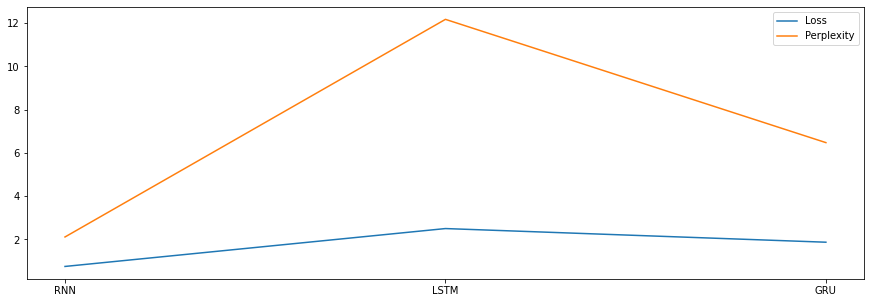

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))
sns.lineplot(x=['RNN','LSTM','GRU'],y=loss,label='Loss')
sns.lineplot(x=['RNN','LSTM','GRU'],y=perplexity,label='Perplexity')